In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime

from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.metrics import roc_curve, roc_auc_score, accuracy_score

In [7]:
# for visual studio code
os.chdir('/home/r10222035/boosted_V_ML_test/BDT/')

# Training sample

In [8]:
kappa = 0.15
nevent = '100k'

In [9]:
sample_dir = f'/home/r10222035/boosted_V_ML_test/sample/samples_kappa{kappa}-{nevent}/'
processes = ['VBF_H5pp_ww_jjjj', 'VBF_H5mm_ww_jjjj', 'VBF_H5z_zz_jjjj']

df_list = []
for name in processes:
    sample_path = os.path.join(sample_dir, name + '_properties.txt')
    df = pd.read_csv(sample_path, index_col=0).replace('W+',0).replace('W-',1).replace('Z',2)
    df_list.append(df)
    
df = pd.concat(df_list)
X = np.array(df.drop('particle type', axis=1))
y = np.array(df['particle type'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [4]:
print(X_train)
print(y_train)

[[ 91.702034     0.35530221]
 [ 90.28263855  -0.81915099]
 [ 80.03176117   1.03147756]
 ...
 [ 87.32333374  -0.67437271]
 [105.36599731  -2.35477583]
 [ 83.09949493   1.04598756]]
[2 2 2 ... 2 2 0]


In [5]:
train_size = [0,0,0]
train_size[0] = (y_train == 0).sum()
train_size[1] = (y_train == 1).sum()
train_size[2] = (y_train == 2).sum()

print('Training:', train_size)

test_size = [0,0,0]
test_size[0] = (y_test == 0).sum()
test_size[1] = (y_test == 1).sum()
test_size[2] = (y_test == 2).sum()
print('Testing:', test_size)
now = datetime.datetime.now()

Training: [14426, 15082, 13045]
Testing: [3532, 3780, 3327]


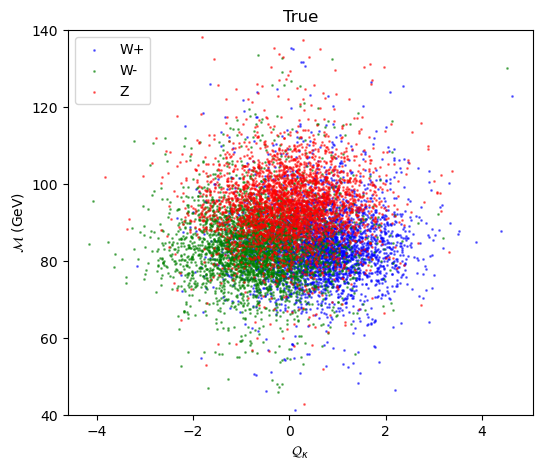

In [6]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
ax.scatter(X_test[y_test==0][:,1], X_test[y_test==0][:,0], s=1, alpha=0.5, c='b', label='W+')
ax.scatter(X_test[y_test==1][:,1], X_test[y_test==1][:,0], s=1, alpha=0.5, c='g', label='W-')
ax.scatter(X_test[y_test==2][:,1], X_test[y_test==2][:,0], s=1, alpha=0.5, c='r', label='Z')

ax.set_title('True')
ax.set_xlabel('$\mathcal{Q}_\kappa$')
ax.set_ylabel('$\mathcal{M}$ (GeV)')

ax.set_ylim([40,140])

ax.legend()

# plt.savefig('figures/True_distribution_of_M_Qk', facecolor='White', dpi=300)
plt.show()

# Training GBDT

In [7]:
GBDT = GradientBoostingClassifier()
GBDT.fit(X_train, y_train)

GradientBoostingClassifier()

In [8]:
now = datetime.datetime.now()

# Training results

In [9]:
acc = GBDT.score(X_test, y_test)
print(f'Overall ACC: {acc:.3}')

Overall ACC: 0.644


In [10]:
# 各類別的機率
GBDT_y_proba = GBDT.predict_proba(X_test)
print(GBDT_y_proba)

[[0.13993815 0.52603596 0.3340259 ]
 [0.31121068 0.60544899 0.08334033]
 [0.0567804  0.51877977 0.42443984]
 ...
 [0.3010432  0.05512709 0.64382971]
 [0.121284   0.82217406 0.05654194]
 [0.07940479 0.22624308 0.69435213]]


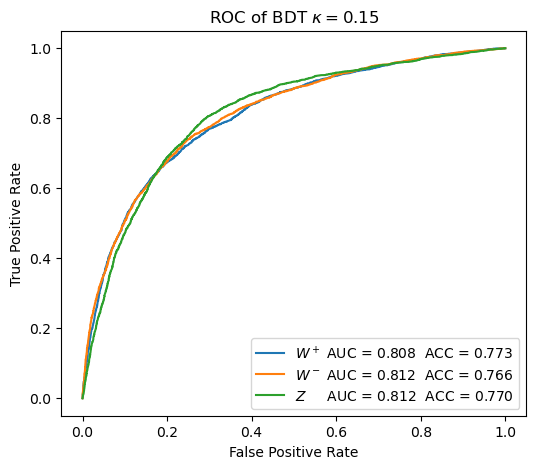

In [11]:
fig, ax = plt.subplots(1,1, figsize=(6,5))
AUC = [0,0,0]
ACC = [0,0,0]
particle_type = {0: '$W^+$', 1: '$W^-$', 2: '$Z$    '}
for i in range(3):
    AUC[i] = roc_auc_score(y_test==i, GBDT_y_proba[:,i])
    
    Gbdt_fpr, Gbdt_tpr, Gbdt_threasholds = roc_curve(y_test==i, GBDT_y_proba[:,i])
    
    # 計算最高的正確率
    accuracy_scores = []
    for threshold in Gbdt_threasholds:
        accuracy_scores.append(accuracy_score(y_test==i, GBDT_y_proba[:,i]>threshold))

    accuracies = np.array(accuracy_scores)
    ACC[i] = accuracies.max() 
    
    ax.plot(Gbdt_fpr, Gbdt_tpr, label = f'{particle_type[i]} AUC = {AUC[i]:.3f}  ACC = {ACC[i]:.3f}')

ax.set_title(f'ROC of BDT $\kappa = {kappa}$')
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.legend()

plt.savefig(f'figures/ROC_BDT_kappa{kappa}-{nevent}.png', facecolor='White', dpi=300)
plt.show()

In [12]:
y_predict = GBDT.predict(X_test)

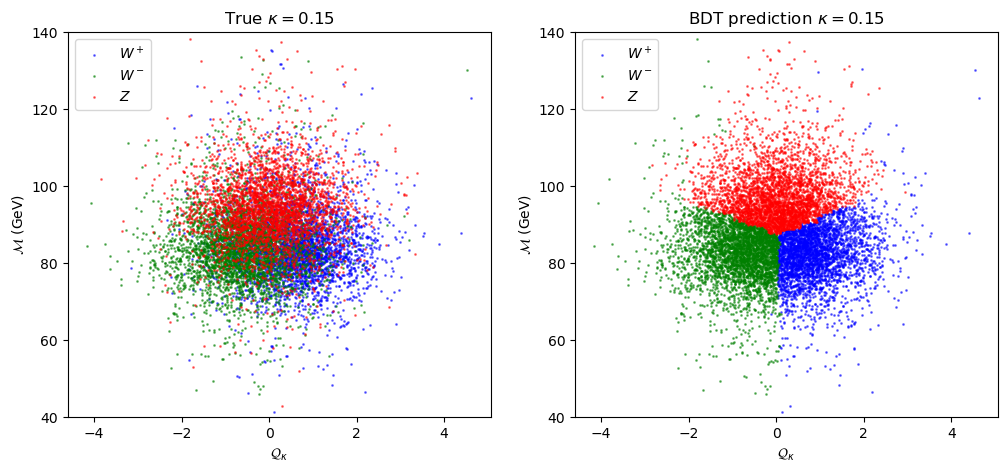

In [13]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
ax[0].scatter(X_test[y_test==0][:,1], X_test[y_test==0][:,0], s=1, alpha=0.5, c='b', label='$W^+$')
ax[0].scatter(X_test[y_test==1][:,1], X_test[y_test==1][:,0], s=1, alpha=0.5, c='g', label='$W^-$')
ax[0].scatter(X_test[y_test==2][:,1], X_test[y_test==2][:,0], s=1, alpha=0.5, c='r', label='$Z$')

ax[0].set_title(f'True $\kappa = {kappa}$')
ax[0].set_xlabel('$\mathcal{Q}_\kappa$')
ax[0].set_ylabel('$\mathcal{M}$ (GeV)')

ax[0].set_ylim([40,140])

ax[0].legend()

ax[1].scatter(X_test[y_predict==0][:,1], X_test[y_predict==0][:,0], s=1, alpha=0.5, c='b', label='$W^+$')
ax[1].scatter(X_test[y_predict==1][:,1], X_test[y_predict==1][:,0], s=1, alpha=0.5, c='g', label='$W^-$')
ax[1].scatter(X_test[y_predict==2][:,1], X_test[y_predict==2][:,0], s=1, alpha=0.5, c='r', label='$Z$')

ax[1].set_title(f'BDT prediction $\kappa = {kappa}$')
ax[1].set_xlabel('$\mathcal{Q}_\kappa$')
ax[1].set_ylabel('$\mathcal{M}$ (GeV)')

ax[1].set_ylim([40,140])

ax[1].legend()

plt.savefig(f'figures/True_and_BDT_distribution_of_M_Qk_kappa{kappa}-{nevent}.png', facecolor='White', dpi=300)
plt.show()

# Write results

In [10]:
file_name = 'BDT_training_results.csv'

In [14]:

df = pd.DataFrame({'kappa': [kappa],
                'Sample': [nevent],
                'Train W+': [train_size[0]],
                'Train W-': [train_size[1]],
                'Train Z':  [train_size[2]],
                'Test W+': [test_size[0]],
                'Test W-': [test_size[1]],
                'Test Z':  [test_size[2]],
                'Overall ACC': [acc],
                'W+ AUC': [AUC[0]],
                'W+ ACC': [ACC[0]],
                'W- AUC': [AUC[1]],
                'W- ACC': [ACC[1]],
                'Z AUC':  [AUC[2]],
                'Z ACC':  [ACC[2]],
                'time': now,
                })
if os.path.isfile(file_name):
    training_results_df = pd.read_csv(file_name)
    pd.concat([training_results_df, df], ignore_index=True).to_csv(file_name, index=False)
else:
    df.to_csv(file_name, index=False)

In [11]:
training_results_df = pd.read_csv(file_name)

In [12]:
training_results_df

,kappa,Sample,Train W+,Train W-,Train Z,Test W+,Test W-,Test Z,Overall ACC,W+ AUC,W+ ACC,W- AUC,W- ACC,Z AUC,Z ACC,time
0,0.15,100k,14426,15082,13045,3532,3780,3327,0.644139,0.808336,0.773005,0.811594,0.765861,0.81213,0.770091,2022-10-05 21:30:47.244185
